In [191]:
from keras.utils import Sequence
import numpy as np
from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import os
import math
from scipy.ndimage import convolve
import params
from glob import glob
import cv2 
from tqdm import tqdm

from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!cat params.py


class data:
    IMG_SHAPE = (112,224,3)
    OUT_SHAPE_1 = (3,7)
    OUT_Layers = 6
    max_h = 0.7
    min_h = -0.5
    max_v = 0.2
    min_v = -0.1

class training:
    network_name = 'mobilenet'
    epoch_end = 10
    batch_size = 16

class model:
    hp_en = True
    eye_en = False

In [61]:
#random number between a and b
def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a


#create a sqare (sizexsizeeee)  gaussian mask with std
def mask_mat(size, std):
    mask = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            mask[i,j] = math.exp(-((size//2 - i)**2 + (size//2 - j)**2 )/std)
    mask = mask/np.sum(np.sum(mask))
    return mask

In [ ]:
class image_loader():
    #eyegaze data is 4:1 ratio (width:height)
    def __init__(self, width=224, height=112):
        #self.sp = SimplePreprocessor(width, height)
        #self.pp = PatchPreprocessor(width, height)
        #mp = MeanPreprocessor(means["R"], means["G"], means["B"])
        #self.iap = ImageToArrayPreprocessor()
        pass
        
    def load_img(self, path):
        #image = cv2.imread(path)
        image = Image.open(path)
        buf = image.copy() #create copy and delete original to overcome PIL bug "Too many open files"
        image.close()
        #image = self.sp.preprocess(image)
        #image = self.mp.preprocess(image)
        #image = self.iap.preprocess(image)
        return buf

In [185]:


class data_generator(Sequence):

    def __init__(self, batch_size, root):
        self.root = root
        self.batch_size = batch_size
        
        self.images = []
        self.labels = []
        self.labels_dict = defaultdict(dict)

        self.img_loader = image_loader()
        
        #paths to each all images
        image_paths = glob(os.path.join(root, 'eye_image', '*', '*.jpg'))
        #paths to all csv files containing coordinates
        label_paths = glob(os.path.join(root, 'eye_image', '*', '*.csv'))


        
        self.IMG_HEIGHT = params.data.IMG_SHAPE[0]
        self.IMG_WIDTH = params.data.IMG_SHAPE[1]



        self.batch_imgs = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, 3))
        self.batch_hp = np.zeros((self.batch_size,6))
        self.batch_points = [None]*params.data.OUT_Layers
        self.mask_size = [3, 5, 9, 19, 31, 63]
        self.mask_std = [1, 2, 10, 50, 100, 300]

        #different resolution 
        for op in range(len(batch_points)):
            self.batch_points[op] = np.zeros((self.batch_size, 3*(2**op), 7*(2**op)))
        
        
        self.load_labels(label_paths)
        self.load_images(image_paths)
        
        
        
        
        
        
    def load_labels(self, files):
        print("Loading labels: ")
        for lab in tqdm(files):
            #extract video name
            video_name = lab.split(os.path.sep)[-2]
            #extract frame name
            df = pd.read_csv(lab, names= ['x', 'y'])
            for frame, row in df.iterrows():
                buf = row.to_numpy() #x,y coordinates of gaze
                self.labels_dict[video_name][frame+1] = buf
                
    #make sure self.labels_dict has been created first
    def load_images(self, files):
        print("Loading images: ")
        for img in tqdm(image_paths):
            #extract video name
            video_name = img.split(os.path.sep)[-2]
            #extract frame name
            frame = int(img.split(os.path.sep)[-1].split('.')[0][5:])

            
            try:
                self.labels.append(labels_dict[video_name][frame])
                self.images.append(img_loader.load_img(img))
                
            except:
                print("Could not find label for frame {} from video {}".format(frame, video_name))


        
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):


        imgs = images[idx * batch_size:(idx + 1) * batch_size]
        gazes = labels[idx * batch_size:(idx + 1) * batch_size]


        #different resolution 
        for op in range(len(self.batch_points)):
            self.batch_points[op] = np.zeros((self.batch_size, 3*(2**op), 7*(2**op)))


        for i in range(0, self.batch_size):
            im = imgs[i]


            iw, ih = im.size
            scale = min(self.IMG_WIDTH / iw, self.IMG_HEIGHT / ih)
            r_scale = rand(.7, 1.3)

            nw = int(iw * scale * r_scale)
            nh = int(ih * scale * r_scale)
            im = im.resize((nw, nh), Image.BICUBIC) #resize to input size using random patch
            new_im = Image.new('RGB', (self.IMG_WIDTH, self.IMG_HEIGHT), (128, 128, 128)) #np.zeros
            new_im.paste(im, ((self.IMG_WIDTH - nw) // 2, (self.IMG_HEIGHT - nh) // 2))
            new_im = np.array(new_im).astype(np.float32) / 255

            # distort image
            hue = 0.1
            sat = 1.5
            val = 1.5
            hue = rand(-hue, hue)
            sat = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
            val = rand(1, val) if rand() < .5 else 1 / rand(1, val)
            x = rgb_to_hsv(new_im)
            x[..., 0] += hue
            x[..., 0][x[..., 0] > 1] -= 1
            x[..., 0][x[..., 0] < 0] += 1
            x[..., 1] *= sat
            x[..., 2] *= val
            x[x > 1] = 1
            x[x < 0] = 0
            new_im = hsv_to_rgb(x)  # numpy array, 0 to 1

            self.batch_imgs[i] = new_im

            point = gazes[i]

            for op in range(len(self.batch_points)):
                mask = mask_mat(self.mask_size[op], self.mask_std[op])
                indv = int(point[1] * (self.IMG_HEIGHT*(2**op)) / 1050)
                indh = int(point[0] * (self.IMG_WIDTH*(2**op)) / 1680)
                target = np.zeros((params.data.OUT_SHAPE_1[0]*(2**op) + mask_size[op] - 1, params.data.OUT_SHAPE_1[1]*(2**op) + mask_size[op] -1))
                target[indv:indv+self.mask_size[op],indh:indh+self.mask_size[op]] = mask
                self.batch_points[op][i] = target[(self.mask_size[op]-1)//2:-(self.mask_size[op]-1)//2,(self.mask_size[op]-1)//2:-(mask_size[op]-1)//2]
        
        return self.batch_imgs, self.batch_points

In [186]:
root = '/home/a/Desktop/MSP-Gaze'

In [187]:
train_data = data_generator(batch_size= 16,root = root)

  0%|          | 0/1188 [00:00<?, ?it/s]

Loading labels: 


  0%|          | 436/324771 [00:00<01:14, 4358.44it/s]

Loading images: 


100%|██████████| 324771/324771 [01:52<00:00, 2881.87it/s]


In [190]:
for x,y in train_data.__getitem__():
    break

TypeError: __getitem__() missing 1 required positional argument: 'idx'

In [100]:
Image.open('/home/a/Desktop/MSP-Gaze/eye_image/Tr_S2_RWH1_F018/image137.jpg').size

(100, 25)

In [101]:
img

'/home/a/Desktop/MSP-Gaze/eye_image/Tr_S2_RWH1_F018/image137.jpg'

In [102]:
img_loader.load_img(img)

  1%|          | 7/1188 [00:00<00:17, 69.30it/s]

Loading labels: 


  0%|          | 321/324771 [00:00<01:41, 3201.42it/s]

Loading images: 


100%|██████████| 324771/324771 [02:01<00:00, 2665.33it/s]


In [120]:
batch_size = 16
idx = 0

In [124]:
IMG_HEIGHT = params.data.IMG_SHAPE[0]
IMG_WIDTH = params.data.IMG_SHAPE[1]

imgs = images[idx * batch_size:(idx + 1) * batch_size]
gazes = labels[idx * batch_size:(idx + 1) * batch_size]


batch_imgs = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 3))
batch_hp = np.zeros((batch_size,6))
batch_points = [None]*params.data.OUT_Layers
mask_size = [3, 5, 9, 19, 31, 63]
mask_std = [1, 2, 10, 50, 100, 300]

#different resolution 
for op in range(len(batch_points)):
    batch_points[op] = np.zeros((batch_size, 3*(2**op), 7*(2**op)))



In [169]:

for i in range(0, batch_size):
#     if params.model.eye_en:
        #drop_eye = rand(0,1) < 0.2
    im = imgs[i]


    iw, ih = im.size
    scale = min(IMG_WIDTH / iw, IMG_HEIGHT / ih)
    r_scale = rand(.7, 1.3)

    nw = int(iw * scale * r_scale)
    nh = int(ih * scale * r_scale)
    im = im.resize((nw, nh), Image.BICUBIC) #resize to input size using random patch
    new_im = Image.new('RGB', (IMG_WIDTH, IMG_HEIGHT), (128, 128, 128)) #np.zeros
    new_im.paste(im, ((IMG_WIDTH - nw) // 2, (IMG_HEIGHT - nh) // 2))
    new_im = np.array(new_im).astype(np.float32) / 255

    # distort image
    hue = 0.1
    sat = 1.5
    val = 1.5
    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
    val = rand(1, val) if rand() < .5 else 1 / rand(1, val)
    x = rgb_to_hsv(new_im)
    x[..., 0] += hue
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x > 1] = 1
    x[x < 0] = 0
    new_im = hsv_to_rgb(x)  # numpy array, 0 to 1

    batch_imgs[i] = new_im
    
    point = gazes[i]
    
    for op in range(len(batch_points)):
        mask = mask_mat(mask_size[op], mask_std[op])
        indv = int(point[1] * (params.data.OUT_SHAPE_1[0]*(2**op)) / 1050)
        indh = int(point[0] * (params.data.OUT_SHAPE_1[1]*(2**op)) / 1680)
        target = np.zeros((params.data.OUT_SHAPE_1[0]*(2**op) + mask_size[op] - 1, params.data.OUT_SHAPE_1[1]*(2**op) + mask_size[op] -1))
        target[indv:indv+mask_size[op],indh:indh+mask_size[op]] = mask
        batch_points[op][i] = target[(mask_size[op]-1)//2:-(mask_size[op]-1)//2,(mask_size[op]-1)//2:-(mask_size[op]-1)//2]

In [167]:
batch_points[5][15]

array([[0.        , 0.        , 0.        , ..., 0.00052354, 0.00049801,
        0.00047057],
       [0.        , 0.        , 0.        , ..., 0.00056904, 0.00054129,
        0.00051147],
       [0.        , 0.        , 0.        , ..., 0.00061438, 0.00058442,
        0.00055222],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

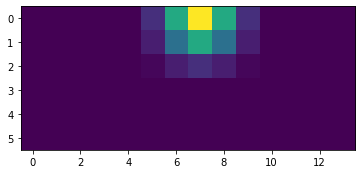

In [173]:
plt.imshow(batch_points[1][2])

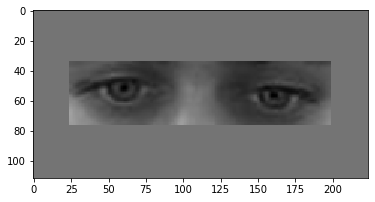

In [135]:
plt.imshow(batch_imgs[0])

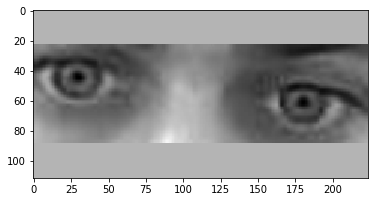

In [118]:
plt.imshow(batch_imgs[12])

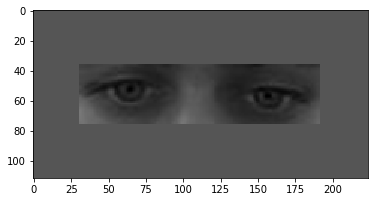

In [116]:
plt.imshow(batch_imgs[0])

In [ ]:
Images:
data aug 

labels:
grid -> gaussian mask

In [18]:
df = pd.read_csv(lab, names= ['x', 'y'])

NameError: name 'lab' is not defined

In [ ]:
row.to_numpy()

In [ ]:
video_name

In [ ]:
videos

In [ ]:
frame

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

from generate_sequence import data_generator
from mobnet_model import model
import scipy.io as sio
import matplotlib.pyplot as plt
from keras.losses import categorical_crossentropy
from keras import backend as K
import os
import params

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


def cc_loss(ytrue, ypred):
    ypred = K.clip(ypred, 1e-14, 1)
    ytrue = K.clip(ytrue, 1e-14, 1)
    cce = -K.sum(K.sum(ytrue * K.log(ypred)))  # /(64*112)
    mae = K.abs(ytrue - ypred)
    return cce + mae


def fl_loss(ytrue, ypred):
    gamma = 1
    ypred = K.clip(ypred, 1e-14, 1)
    ytrue = K.clip(ytrue, 1e-14, 1)
    cce = -K.sum(K.sum(ytrue * ((1 - ypred) ** gamma) * K.log(ypred)))  # /(64*112)
    return cce

hist = {}
model = model()
save_model_loc = 'model_fusion_eyedrop20/'
os.mkdir(save_model_loc)
filepath = save_model_loc + 'model-{epoch:02d}-{val_loss:.2f}.hdf5'
cb = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='max', save_weights_only=True)
# images driver and head pose
train_images, train_bb, train_angles, train_hp, val_images, val_bb, val_angles, val_hp = list_of_data_angles.list_of_data()
train_images_mark, train_bb_mark, train_angles_mark, train_hp_mark, val_images_mark, val_bb_mark, val_angles_mark, val_hp_mark = list_of_data_angles_markers.list_of_data()
train_images, train_bb, train_angles, train_hp = list_of_data_angles.rep_data_for_balance(train_images, train_bb, train_angles, train_hp)
print('total training points ' + str(len(train_images)))
print('total validation points ' + str(len(val_images)))
print('total training points marker' + str(len(train_images_mark)))
print('total validation points  marker' + str(len(val_images_mark)))

# end-to-end
loss_weights_sequence = [1, 1, 1, 1, 1, 1]

lr_seq = 1e-3
batch_size_all = 16
prev_epoch = 0
n_epochs = 1

opt = Adam(lr=lr_seq)
model.model.compile(loss=[cc_loss] * 6, loss_weights=loss_weights_sequence, optimizer=opt)